In [40]:
from lib.ekyn import *
from lib.utils import *
from lib.env import *
from lib.models import MLP

from sklearn.model_selection import train_test_split
import joblib

from lib.datasets import Dataset2p0
from torch.utils.data import DataLoader,TensorDataset
import torch
from torch import nn
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neural_network import MLPClassifier
from lib.utils import UniformRandomClassifier,ProportionalRandomClassifier

In [42]:
X,y = load_psd_label_pairs_windowed(get_ekyn_ids())
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2,shuffle=True,random_state=0)
X_train,X_dev,y_train,y_dev = train_test_split(X_train,y_train,test_size=.25,shuffle=True,random_state=0)
trainloader = DataLoader(TensorDataset(X_train,y_train),batch_size=32,shuffle=True)
devloader = DataLoader(TensorDataset(X_dev,y_dev),batch_size=32,shuffle=True)
testloader = DataLoader(TensorDataset(X_test,y_test),batch_size=32,shuffle=True)

In [43]:
class CustomMLP(nn.Module):
    """
    MLP according to Wang et. al (proposed as 
    a baseline architecture for TSC)
    """
    def __init__(self,input_size=5000,hidden_sizes=(500,500,500)) -> None:
        super().__init__()
        self.fc1 = nn.Linear(input_size,hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0],3)

    def forward(self,x):
        x = self.fc1(x)
        x = relu(x)
        x = self.fc2(x)
        return x

In [66]:
model = CustomMLP(input_size=210,hidden_sizes=(512,)).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=3e-4)

In [67]:
loss_tr = []
loss_dev = []

In [68]:
model.train()

for i in range(100):
    loss_tr_total = 0

    for (X_tr,y_tr) in tqdm(trainloader):
        X_tr,y_tr = X_tr.to(DEVICE),y_tr.to(DEVICE)
        logits = model(X_tr)
        loss = criterion(logits,y_tr)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_tr_total += loss.item()
    loss_tr.append(loss_tr_total/len(trainloader))

    with torch.no_grad():
        loss_dev_total = 0
        for (X_dv,y_dv) in devloader:
            X_dv,y_dv = X_dv.to(DEVICE),y_dv.to(DEVICE)
            logits = model(X_dv)
            loss = criterion(logits,y_dv)
            loss_dev_total += loss.item()
        loss_dev.append(loss_dev_total/len(devloader))
    plt.plot(loss_tr[-20:])
    plt.plot(loss_dev[-20:])
    plt.savefig('loss.jpg')
    plt.close()

100%|██████████| 5184/5184 [00:04<00:00, 1208.53it/s]


0.29031763265676863


{'precision': 0.869121553299911,
 'recall': 0.8400740661947728,
 'f1': 0.8534581417780625}

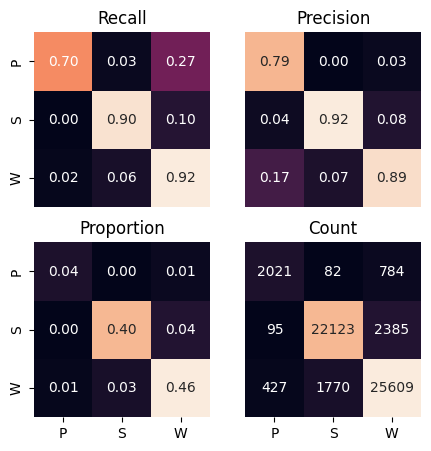

In [58]:
loss,metrics,y_true,y_pred,y_logits = evaluate(testloader,model,criterion)
cm_grid(y_true,y_pred)
# {'precision': 0.869121553299911,
#  'recall': 0.8400740661947728,
#  'f1': 0.8534581417780625}
print(loss)
metrics

In [59]:
joblib.dump(model,'psd_MLP_shuffle_split.joblib')

['psd_MLP_shuffle_split.joblib']